## Sampled Population Simulations

In [1]:
import os
import sys
import glob
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [91]:
from multiprocessing import Pool
from functools import partial
import pandas as pd
import scipy
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import statsmodels.api as sm
import matplotlib as mpl
import matplotlib.colors as mcolors

In [8]:
from cvtk.cvtk import TemporalFreqs, TiledTemporalFreqs
from cvtk.cov import stack_temporal_covariances
import cvtk.slimfile as sf
from cvtk.process_sims import extract_runs, load_pickled, load_stats, CI_polygon
from cvtk.process_sims import params_vary_over, col_palette, average_runs
from cvtk.process_sims import covs_from_twopop
from cvtk.gintervals import GenomicIntervals
from cvtk.plots import rep_plot_pca, correction_diagnostic_plot
from cvtk.utils import integerize
from cvtk.cov import stack_replicate_covariances, stack_temporal_covs_by_group

In [293]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'
mpl.rcParams['figure.figsize'] = (8.0, 4.0)
mpl.rcParams['figure.dpi'] = 200
plt.style.use('plots/buffalo.mplstyle')

# image sizes
ONECOL = 3.42
THREEHALVESCOL = 4.5
TWOCOL = 7

In [5]:
DATADIR = "../data/sims_intermediate/split_gss/"
SIMDIR = "../data/sims/split_gss/"

In [25]:
converters = dict(N=int, alpha=float, nmu=float, rbp=float, tmu=float,
                  mag=float, Va=float, L = int, shift=float,
                  region_length=int, sampleN=int, shifttime=int, tail=float)
gss_results = load_pickled(DATADIR, converters=converters)
gss_stats = load_stats(SIMDIR, converters=converters)

In [26]:
params_vary_over(gss_results)

defaultdict(set,
            {'N': {1000},
             'Vs': {'1'},
             'alpha': {0.01},
             'moving': {'F', 'T'},
             'nmu': {1e-08},
             'rbp': {5e-09, 1e-08},
             'region_length': {50000000},
             'sampleN': {50, 100, 200, 1000},
             'shift': {0.001, 0.01, 0.1, 0.5, 1.0},
             'shifttime': {5},
             'shifttype': {'converge', 'diverge', 'single'},
             'tmu': {1e-10, 1e-09, 1e-08}})

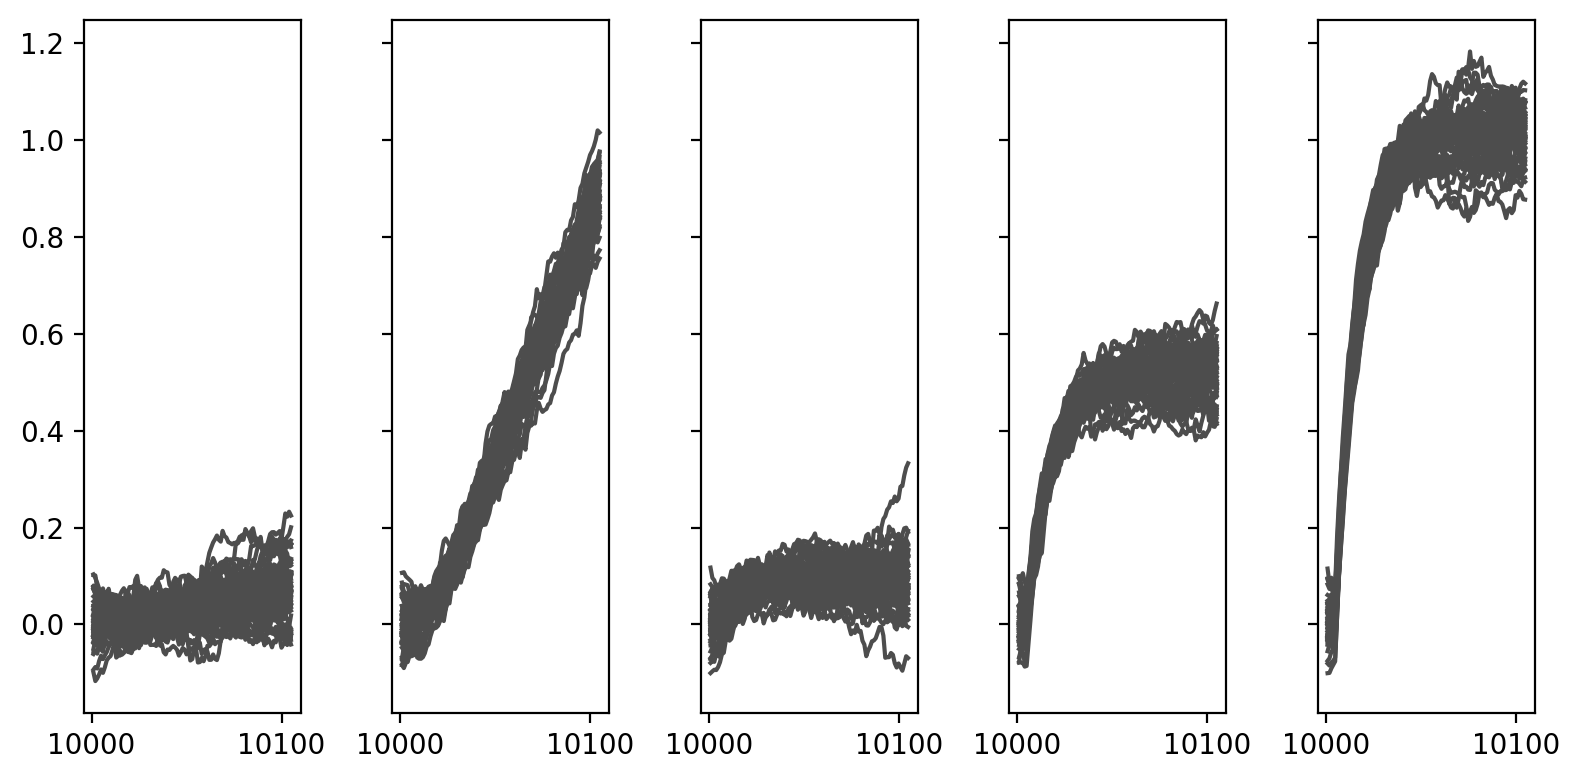

In [57]:
stats_subset = extract_runs({'rbp':[1e-8], 'sampleN':[1000], 
                              'N':[1000], 'tmu':[1e-8],
                              'shifttype': ['converge']}, gss_stats)

subset_params = params_vary_over(stats_subset)
tmus = sorted(subset_params['tmu'])
shift_params = [(dict(x)['moving'], dict(x)['shift']) for x in stats_subset]

fix, ax = plt.subplots(ncols = len(shift_params), nrows=1, sharey=True)


for i, (moving, shift) in enumerate(shift_params):
    d = extract_runs({'shift':[shift], 'tmu':[tmu]}, stats_subset)
    assert(len(d.keys()) == 1)
    for run in list(d.values())[0]:
        ax[i].plot(run.generation, run.zbar_1, c='0.3')
            
plt.tight_layout()

/home/vsb/miniconda3/envs/cvtk/lib/python3.7/site-packages/ipykernel_launcher.py:53: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


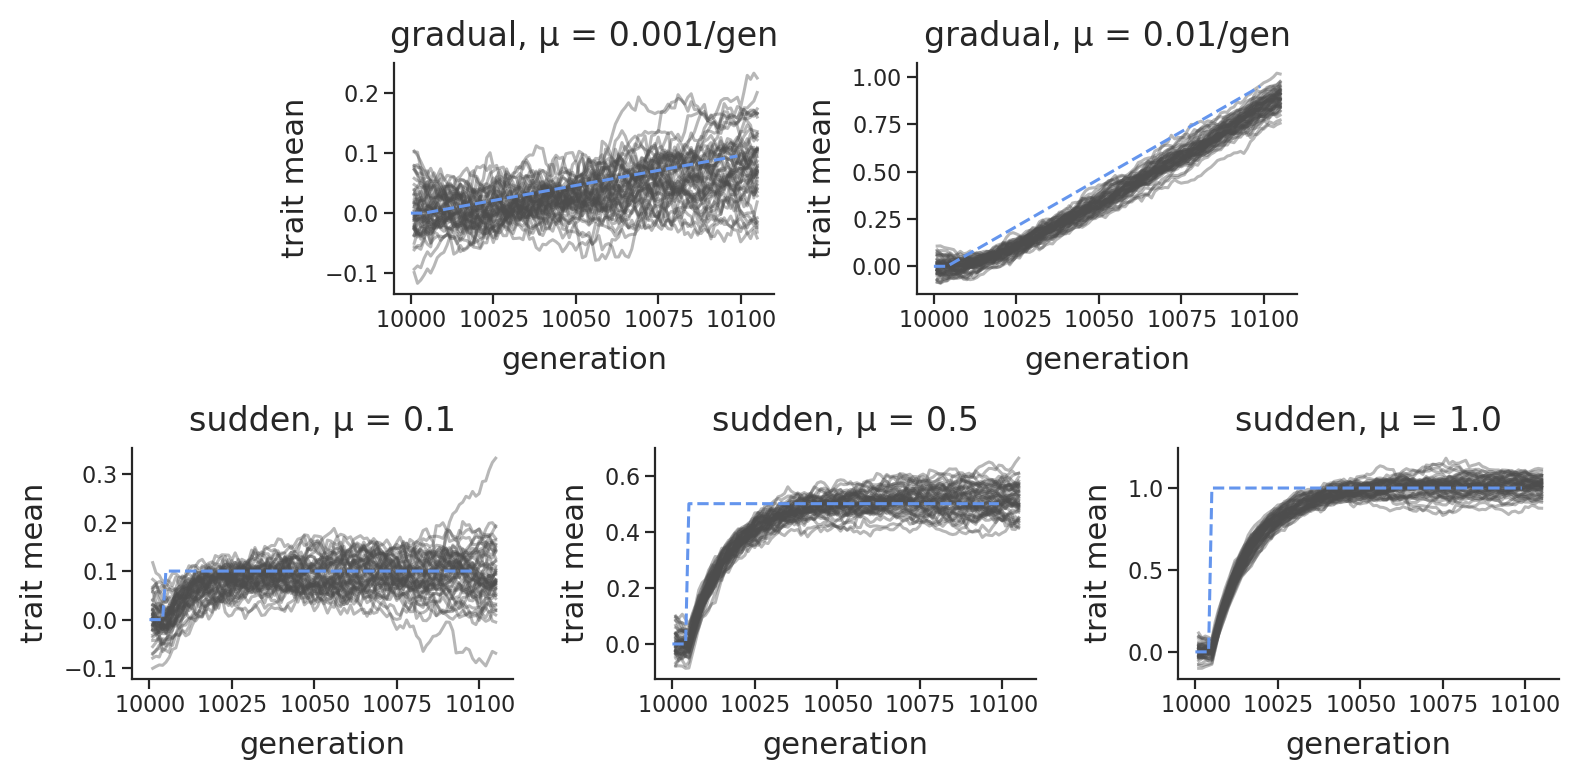

In [891]:
def zbar_plot(stats, ax, moving, shift):
    d = extract_runs({'shift':[shift]}, stats)
    assert(len(d.keys()) == 1)
    x, y = []
    for run in list(d.values())[0]:
        ax.plot(run.generation, run.zbar_1, c='0.3')
        x.append(run.generation.values)
        y.append(run.zbar_1.values)
    ax.axhline(0, c='0.5', linewidth=0.5, linestyle=(0, (5, 5)))   
    ax.plot(np.array(x).mean(axis=0), np.array(y).mean(axis=0),  c='r', linewidth=3)
    label = f"{'gradual' if moving == 'T' else 'sudden'}, μ = {shift}σ{'/gen' if moving == 'T' else ''}"
    ax.set_title(label)
    ax.set_ylabel('trait mean')
    ax.set_xlabel('generation')

stats_subset = extract_runs({'rbp':[1e-8], 'sampleN':[1000], 
                              'N':[1000], 'tmu':[1e-8],
                              'shifttype': ['converge']}, gss_stats)

subset_params = params_vary_over(stats_subset)
tmus = sorted(subset_params['tmu'])
shift_params = [(dict(x)['moving'], dict(x)['shift']) for x in stats_subset]

fig = plt.figure(constrained_layout=True)
gs = fig.add_gridspec(2, 6)

axs = [fig.add_subplot(gs[0, 1:3]),
       fig.add_subplot(gs[0, 3:5]),
       fig.add_subplot(gs[1, 0:2]),
       fig.add_subplot(gs[1, 2:4]),
       fig.add_subplot(gs[1, 4:6])]


for (moving, shift), ax in zip(shift_params, axs):
    d = extract_runs({'shift':[shift]}, stats_subset)
    assert(len(d.keys()) == 1)
    for run in list(d.values())[0]:
        ax.plot(run.generation, run.zbar_1, c='0.3', alpha=0.4)
    ax.set_ylabel('trait mean')
    ax.set_xlabel('generation')
    label = f"{'gradual' if moving == 'T' else 'sudden'}, μ = {shift}{'/gen' if moving == 'T' else ''}"
    ax.set_title(label)
    if moving == 'F':
        #ax.axhline(shift, c='cornflowerblue', linestyle='--')
        x = np.arange(10000, 10100)
        y = [shift if i >= 10000 + 5 else 0 for i in x]
        ax.plot(x, y, '--', c='cornflowerblue')
    else:        
        x = np.arange(10000, 10100)
        y = [shift * (i - 10000 - 4) if i >= 10000 + 5 else 0 for i in x]
        ax.plot(x, y, '--', c='cornflowerblue')
    
plt.tight_layout()
fig.savefig("plots/gss-zbar.pdf", bbox_inches='tight')

In [884]:
params_vary_over(stats_subset)

defaultdict(set,
            {'N': {1000},
             'Vs': {'1'},
             'alpha': {0.01},
             'moving': {'F'},
             'nmu': {1e-08},
             'rbp': {1e-08},
             'region_length': {50000000},
             'sampleN': {50, 100, 200, 1000},
             'shift': {1.0},
             'shifttime': {5},
             'shifttype': {'converge'},
             'tmu': {1e-08}})

/home/vsb/miniconda3/envs/cvtk/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


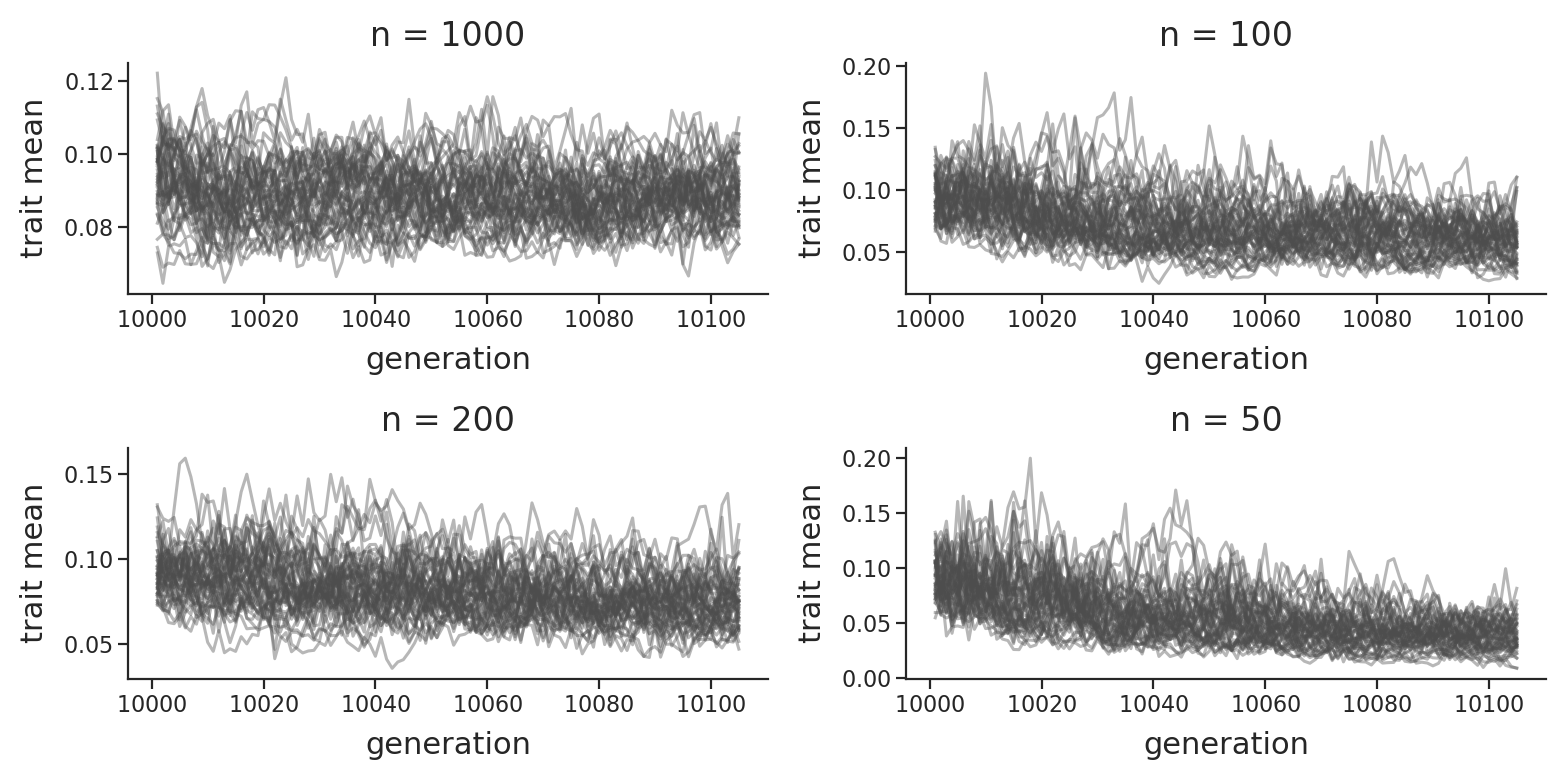

In [889]:
stats_subset = extract_runs({'rbp':[1e-8], 
                              'N':[1000], 'tmu':[1e-8], 'moving':['F'], 'shift':[1],
                              'shifttype': ['converge']}, gss_stats)

subset_params = params_vary_over(stats_subset)
tmus = sorted(subset_params['tmu'])
sampleN_params = [dict(x)['sampleN'] for x in stats_subset]

fig = plt.figure(constrained_layout=True)
gs = fig.add_gridspec(2, 2)

axs = [fig.add_subplot(gs[0, 0]),
       fig.add_subplot(gs[0, 1]),
       fig.add_subplot(gs[1, 0]),
       fig.add_subplot(gs[1, 1])]


for samplen, ax in zip(sampleN_params, axs):
    d = extract_runs({'sampleN':[samplen]}, stats_subset)
    assert(len(d.keys()) == 1)
    for run in list(d.values())[0]:
        ax.plot(run.generation, run.zvar_1, c='0.3', alpha=0.4)
    ax.set_ylabel('trait variance')
    ax.set_xlabel('generation')
    label = f"n = {samplen}"
    ax.set_title(label)
    
plt.tight_layout()
#fig.savefig("plots/gss-zbar.pdf", bbox_inches='tight')

## G

In [62]:
covs_subset = extract_runs({'rbp':[1e-8], 'sampleN':[1000], 
                              'N':[1000], 'tmu':[1e-8],
                              'shifttype': ['converge']},
                              gss_results)

In [818]:
params_vary_over(covs_subset)

defaultdict(set,
            {'N': {1000},
             'Vs': {'1'},
             'alpha': {0.01},
             'moving': {'F', 'T'},
             'nmu': {1e-08},
             'rbp': {1e-08},
             'region_length': {50000000},
             'sampleN': {1000},
             'shift': {0.001, 0.01, 0.1, 0.5, 1.0},
             'shifttime': {5},
             'shifttype': {'converge'},
             'tmu': {1e-08}})

/home/vsb/miniconda3/envs/cvtk/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


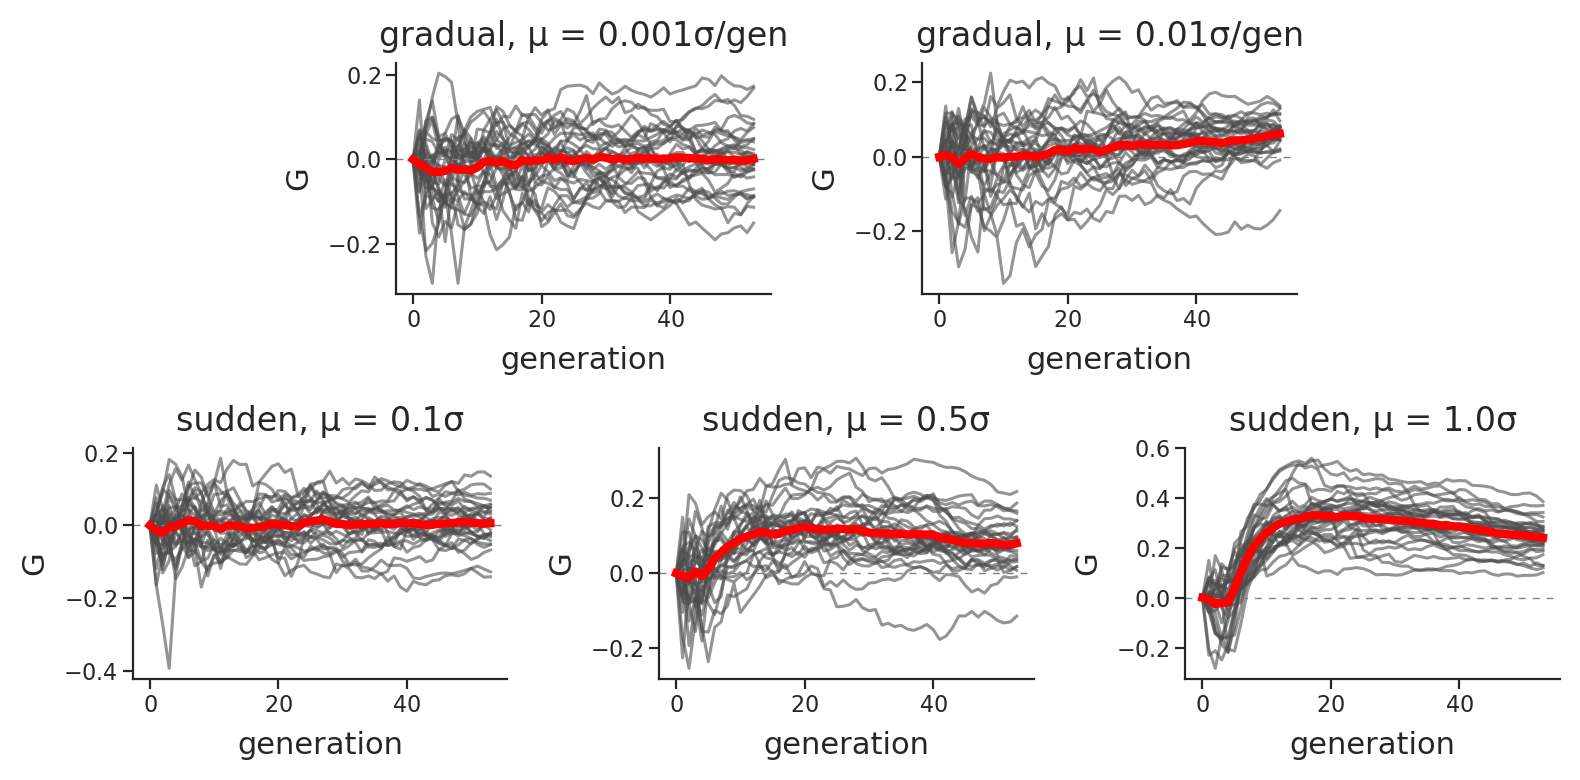

In [338]:
def G_plot(covs, ax, moving, shift, color='0.3', linecolor='red', linealpha=1.0, Galpha=0.6, title=True):
    d = extract_runs({'shift':[shift]}, covs)
    assert(len(d.keys()) == 1)
    all = []
    for run in list(d.values())[0]:
        ax.plot(run[1][:, 0], c=color, alpha=Galpha)
        all.append(run[1][:, 0])
    ax.axhline(0, c='0.5', linewidth=0.5, linestyle=(0, (5, 5)))   
    ax.plot(np.stack(all).mean(axis=0), c=linecolor, linewidth=3, alpha=linealpha, zorder=3)
    label = f"{'gradual' if moving == 'T' else 'sudden'}, μ = {shift}σ{'/gen' if moving == 'T' else ''}"
    if title:
        ax.set_title(label)
    ax.set_ylabel('G')
    ax.set_xlabel('generation')



subset_params = params_vary_over(covs_subset)
tmus = sorted(subset_params['tmu'])
shift_params = [(dict(x)['moving'], dict(x)['shift']) for x in covs_subset]

fig = plt.figure(constrained_layout=True)
gs = fig.add_gridspec(2, 6)

axs = [fig.add_subplot(gs[0, 1:3]),
       fig.add_subplot(gs[0, 3:5]),
       fig.add_subplot(gs[1, 0:2]),
       fig.add_subplot(gs[1, 2:4]),
       fig.add_subplot(gs[1, 4:6])]

for (moving, shift), ax in zip(shift_params, axs):
    G_plot(covs_subset, ax, moving, shift)
plt.tight_layout()
fig.savefig("plots/gss-G.pdf", bbox_inches='tight')

# Split G

In [849]:
covs_subset_split = extract_runs({'rbp':[1e-8], 'moving':['F'],
                                  'shift':[1],
                                  'N':[1000], 'tmu':[1e-8],
                                  'shifttype': ['converge']},
                                   gss_results)
params_vary_over(covs_subset_split)

defaultdict(set,
            {'N': {1000},
             'Vs': {'1'},
             'alpha': {0.01},
             'moving': {'F'},
             'nmu': {1e-08},
             'rbp': {1e-08},
             'region_length': {50000000},
             'sampleN': {50, 100, 200, 1000},
             'shift': {1.0},
             'shifttime': {5},
             'shifttype': {'converge'},
             'tmu': {1e-08}})

In [850]:
sampleN_params

[50, 100, 200, 1000]

/home/vsb/miniconda3/envs/cvtk/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


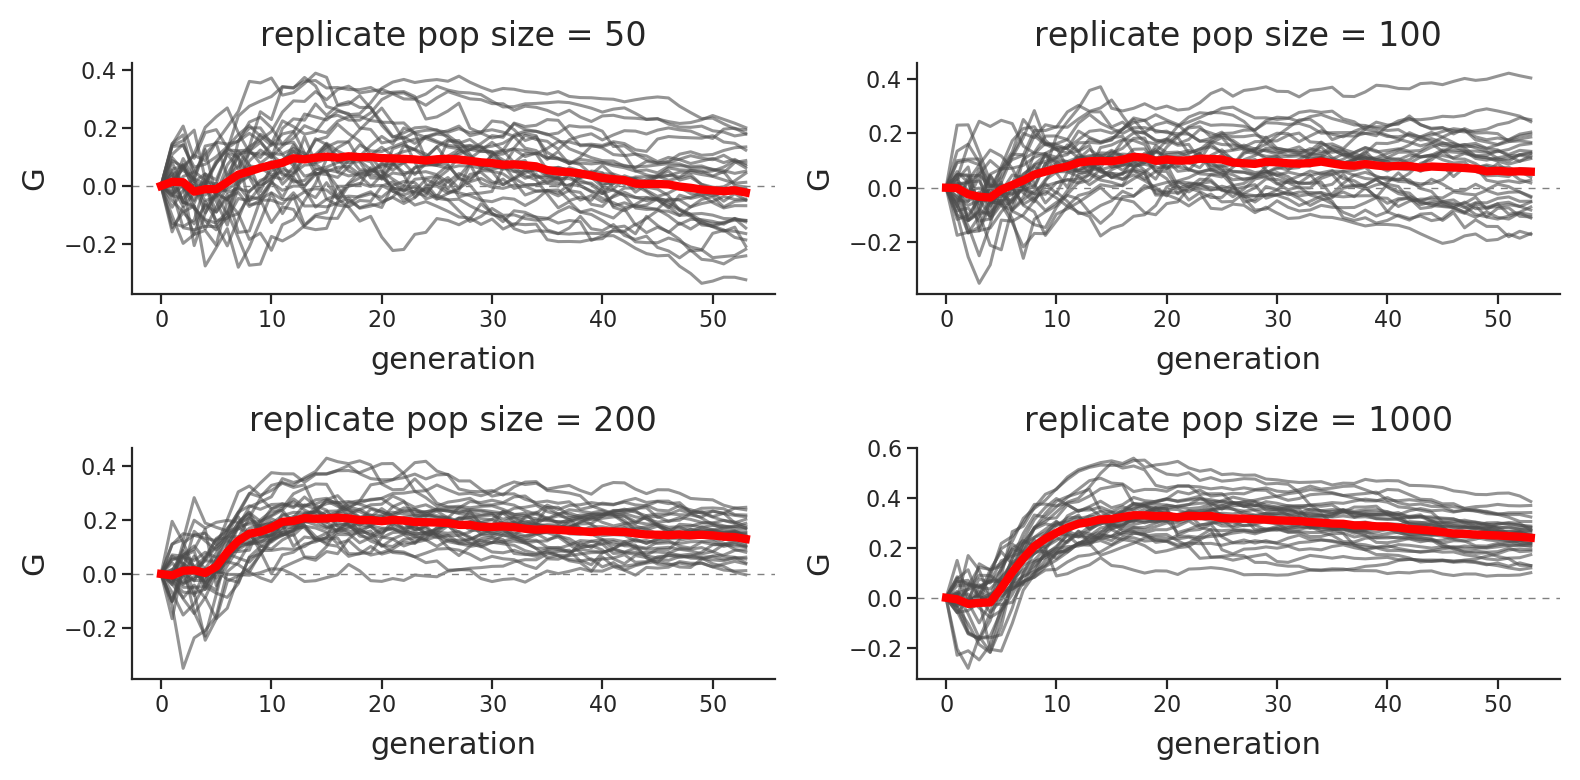

In [892]:
subset_params = params_vary_over(covs_subset_split)

sampleN_params = sorted([dict(x)['sampleN'] for x in covs_subset_split])
color='0.3'
linecolor='red'
linealpha=1.0
Galpha=0.6
title=True

fig = plt.figure(constrained_layout=True)
gs = fig.add_gridspec(2, 2)

axs = [fig.add_subplot(gs[0, 0]),
       fig.add_subplot(gs[0, 1]),
       fig.add_subplot(gs[1, 0]),
       fig.add_subplot(gs[1, 1])]

for n, ax in zip(sampleN_params, axs):
    d = extract_runs({'sampleN':[n]}, covs_subset_split)
    assert(len(d.keys()) == 1)
    all = []
    for run in list(d.values())[0]:
        ax.plot(run[1][:, 0], c=color, alpha=Galpha)
        all.append(run[1][:, 0])
    ax.axhline(0, c='0.5', linewidth=0.5, linestyle=(0, (5, 5)))   
    ax.plot(np.stack(all).mean(axis=0), c=linecolor, linewidth=3, alpha=linealpha, zorder=3)
    label = f"replicate pop size = {n}"
    if title:
        ax.set_title(label)
    ax.set_ylabel('G')
    ax.set_xlabel('generation')
plt.tight_layout()
fig.savefig("plots/gss-G-sampleN.pdf", bbox_inches='tight')

## Covariances

In [852]:
lowess = sm.nonparametric.lowess

In [853]:
stacked_covs_subset = average_runs(covs_subset)

/home/vsb/miniconda3/envs/cvtk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


/home/vsb/miniconda3/envs/cvtk/lib/python3.7/site-packages/ipykernel_launcher.py:47: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


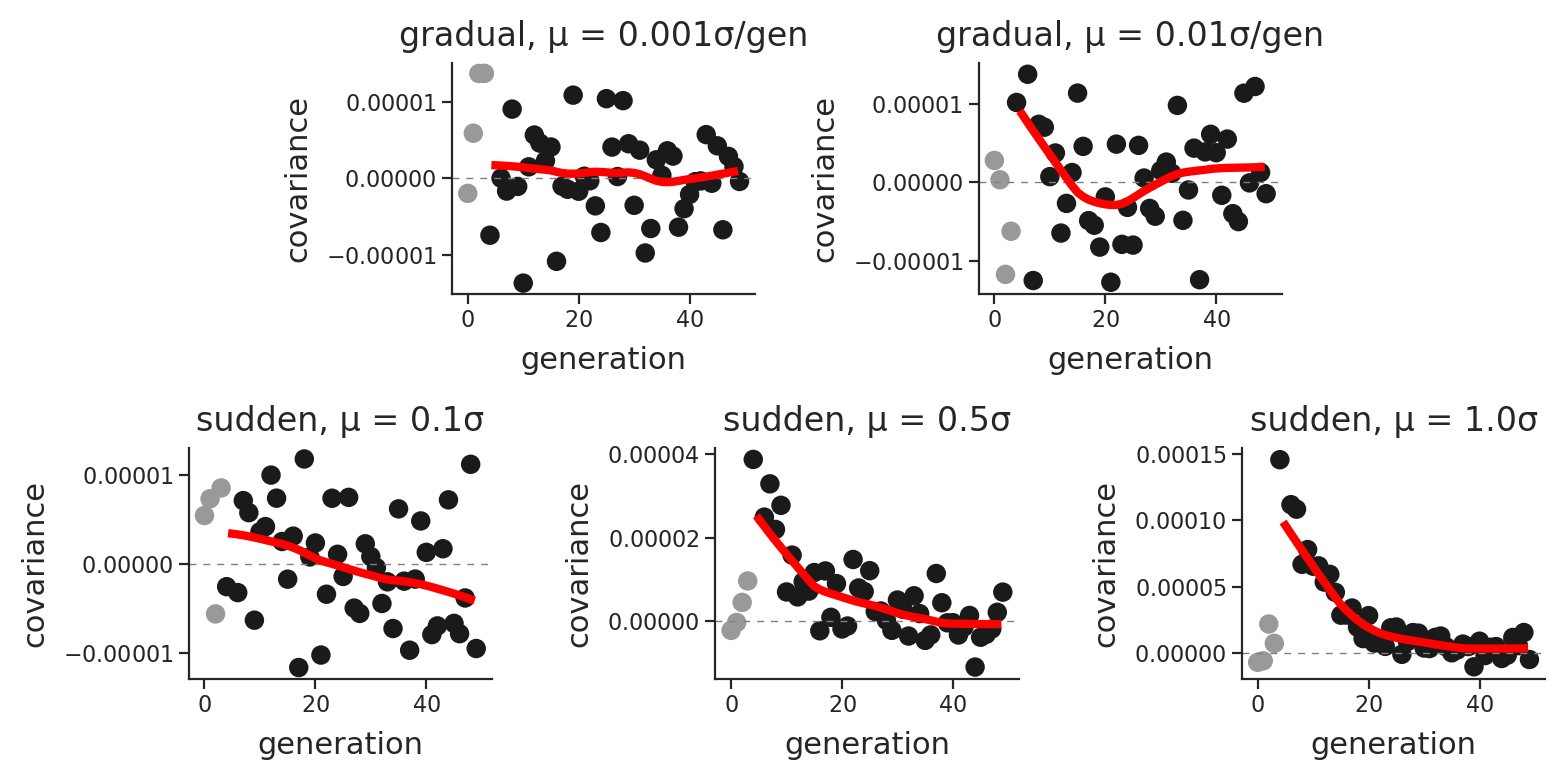

In [860]:
subset_params = params_vary_over(stacked_covs_subset)
tmus = sorted(subset_params['tmu'])
shift_params = [(dict(x)['moving'], dict(x)['shift']) for x in stacked_covs_subset]

lightgray, darkgray = (0.6, 0.6, 0.6), (0.1, 0.1, 0.1)
ref = 5
maxgen = 50
yscale = 1

def covs_plot(covs, ax, moving, shift, ylim=None, linewidth=3, 
              colors = ((0.6, 0.6, 0.6), (0.1, 0.1, 0.1)), title=True,
             linecolor='red', linealpha=1.0):
    d = extract_runs({'shift':[shift]}, covs)
    all = []
    for run in list(d.values()):            
        tempcovs = stack_temporal_covariances(run[0].mean(axis=0), run[3][0], run[3][1])
        n = tempcovs[0].shape[0]
        idx = (np.arange(n) != ref) & (np.arange(n) < maxgen)
        ax.axhline(0, c='0.5', linewidth=0.5, linestyle=(0, (5, 5)))
        cols = [colors[0] if i < ref-1 else colors[1] for i in range(maxgen-1)]
        selgen = np.arange(ref, maxgen-1)
        fit = lowess(tempcovs[ref, idx, 1][selgen],
                     selgen, frac=1/2, return_sorted=True)

        ax.plot(fit[:, 0], yscale * fit[:, 1], '-', c=linecolor, linewidth=linewidth, alpha=linealpha)
        ax.scatter(np.where(idx)[0], yscale * tempcovs[ref, idx, 1], c=cols)
        if ylim is not None:
            ax.set_ylim(*ylim)
        label = f"{'gradual' if moving == 'T' else 'sudden'}, μ = {shift}σ{'/gen' if moving == 'T' else ''}"
        if title:
            ax.set_title(label)
        ax.set_ylabel('covariance')
        ax.set_xlabel('generation')

fig = plt.figure(constrained_layout=True)
gs = fig.add_gridspec(2, 6)

axs = [fig.add_subplot(gs[0, 1:3]),
       fig.add_subplot(gs[0, 3:5]),
       fig.add_subplot(gs[1, 0:2]),
       fig.add_subplot(gs[1, 2:4]),
       fig.add_subplot(gs[1, 4:6])]

for (moving, shift), ax in zip(shift_params, axs):
    covs_plot(stacked_covs_subset, ax, moving, shift, ylim=None)
    
plt.tight_layout()
fig.savefig("plots/gss-covs.pdf", bbox_inches='tight')

/home/vsb/miniconda3/envs/cvtk/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


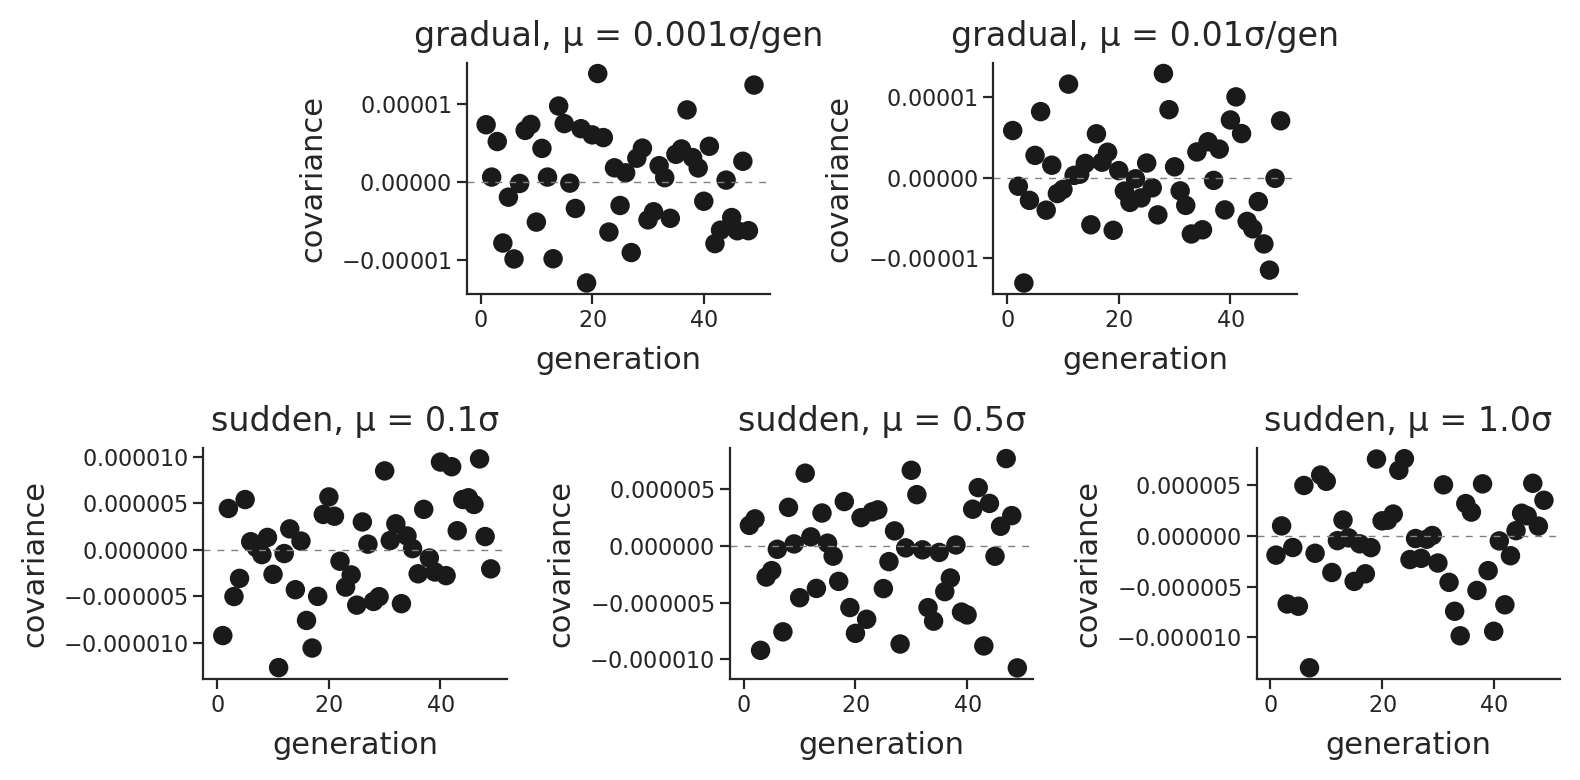

In [268]:
subset_params = params_vary_over(stacked_covs_subset)
tmus = sorted(subset_params['tmu'])
shift_params = [(dict(x)['moving'], dict(x)['shift']) for x in stacked_covs_subset]

lightgray, darkgray = (0.6, 0.6, 0.6), (0.1, 0.1, 0.1)
ref = 0
maxgen = 50
yscale = 1


fig = plt.figure(constrained_layout=True)
gs = fig.add_gridspec(2, 6)

axs = [fig.add_subplot(gs[0, 1:3]),
       fig.add_subplot(gs[0, 3:5]),
       fig.add_subplot(gs[1, 0:2]),
       fig.add_subplot(gs[1, 2:4]),
       fig.add_subplot(gs[1, 4:6])]

for (moving, shift), ax in zip(shift_params, axs):
    covs_plot(stacked_covs_subset, ax, moving, shift, ylim=None, linewidth=0)
    
plt.tight_layout()
fig.savefig("plots/gss-covs-gen40.pdf", bbox_inches='tight')

/home/vsb/miniconda3/envs/cvtk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/vsb/miniconda3/envs/cvtk/lib/python3.7/site-packages/ipykernel_launcher.py:54: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


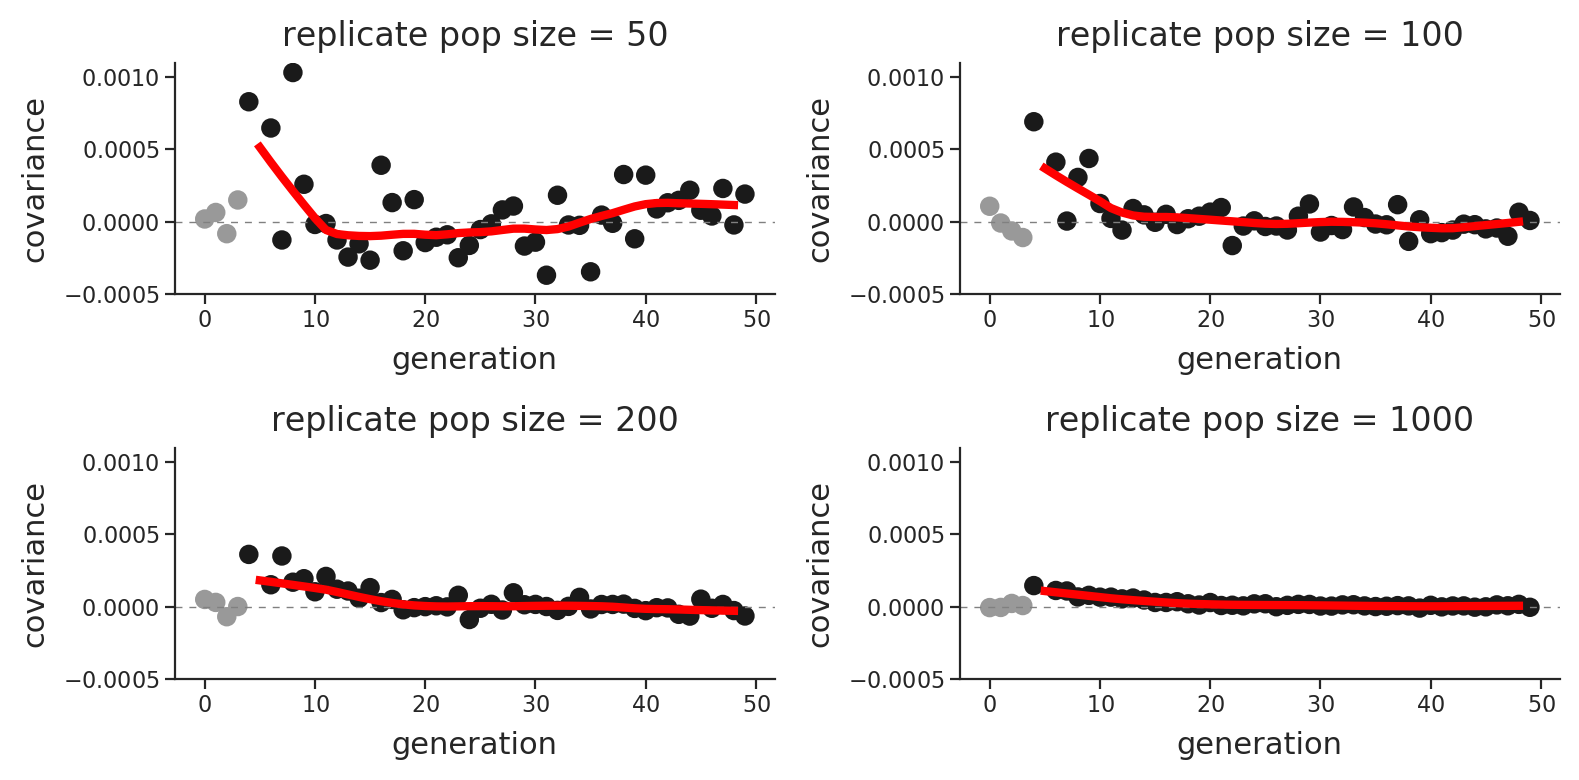

In [893]:


stacked_covs_subset_split = average_runs(covs_subset_split)
subset_params = params_vary_over(stacked_covs_subset_split)

sampleN_params = sorted([dict(x)['sampleN'] for x in stacked_covs_subset_split])
color='0.3'
linecolor='red'
linealpha=1.0
Galpha=0.6
title=True


linewidth=3
colors = ((0.6, 0.6, 0.6), (0.1, 0.1, 0.1))
title=True
linecolor='red'
linealpha=1.0
ref = 5
maxgen = 50
yscale = 1
ylim = (-0.0005, 0.0011)

fig = plt.figure(constrained_layout=True)
gs = fig.add_gridspec(2, 2)

axs = [fig.add_subplot(gs[0, 0]),
       fig.add_subplot(gs[0, 1]),
       fig.add_subplot(gs[1, 0]),
       fig.add_subplot(gs[1, 1])]

for samplen, ax in zip(sampleN_params, axs):
    d = extract_runs({'sampleN':[samplen]}, stacked_covs_subset_split)
    assert(len(d) == 1)
    all = []
    for run in list(d.values()):            
        tempcovs = stack_temporal_covariances(run[0].mean(axis=0), run[3][0], run[3][1])
        n = tempcovs[0].shape[0]
        idx = (np.arange(n) != ref) & (np.arange(n) < maxgen)
        ax.axhline(0, c='0.5', linewidth=0.5, linestyle=(0, (5, 5)))
        cols = [colors[0] if i < ref-1 else colors[1] for i in range(maxgen-1)]
        selgen = np.arange(ref, maxgen-1)
        fit = lowess(tempcovs[ref, idx, 1][selgen],
                     selgen, frac=1/3, return_sorted=True)

        ax.plot(fit[:, 0], yscale * fit[:, 1], '-', c=linecolor, linewidth=linewidth, alpha=linealpha)
        ax.scatter(np.where(idx)[0], yscale * tempcovs[ref, idx, 1], c=cols)
        if ylim is not None:
            ax.set_ylim(*ylim)
        label = f"replicate pop size = {samplen}"
        if title:
            ax.set_title(label)
        ax.set_ylabel('covariance')
        ax.set_xlabel('generation')

plt.tight_layout()
fig.savefig("plots/gss-covs-sampleN.pdf", bbox_inches='tight')

## Convergent Correlation

In [453]:
covs_2pop_subset = extract_runs({'moving': ['F'], 'tmu':[1e-8], 'rbp':[1e-8],
                                'sampleN':[50, 500, 1000]},
                                gss_results)

In [454]:
covs_2pop_ave = average_runs(covs_2pop_subset)

/home/vsb/miniconda3/envs/cvtk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [455]:
params_2pop = params_vary_over(covs_2pop_ave)
params_2pop

defaultdict(set,
            {'N': {1000},
             'Vs': {'1'},
             'alpha': {0.01},
             'moving': {'F'},
             'nmu': {1e-08},
             'rbp': {1e-08},
             'region_length': {50000000},
             'sampleN': {50, 1000},
             'shift': {0.1, 0.5, 1.0},
             'shifttime': {5},
             'shifttype': {'converge', 'diverge', 'single'},
             'tmu': {1e-08}})

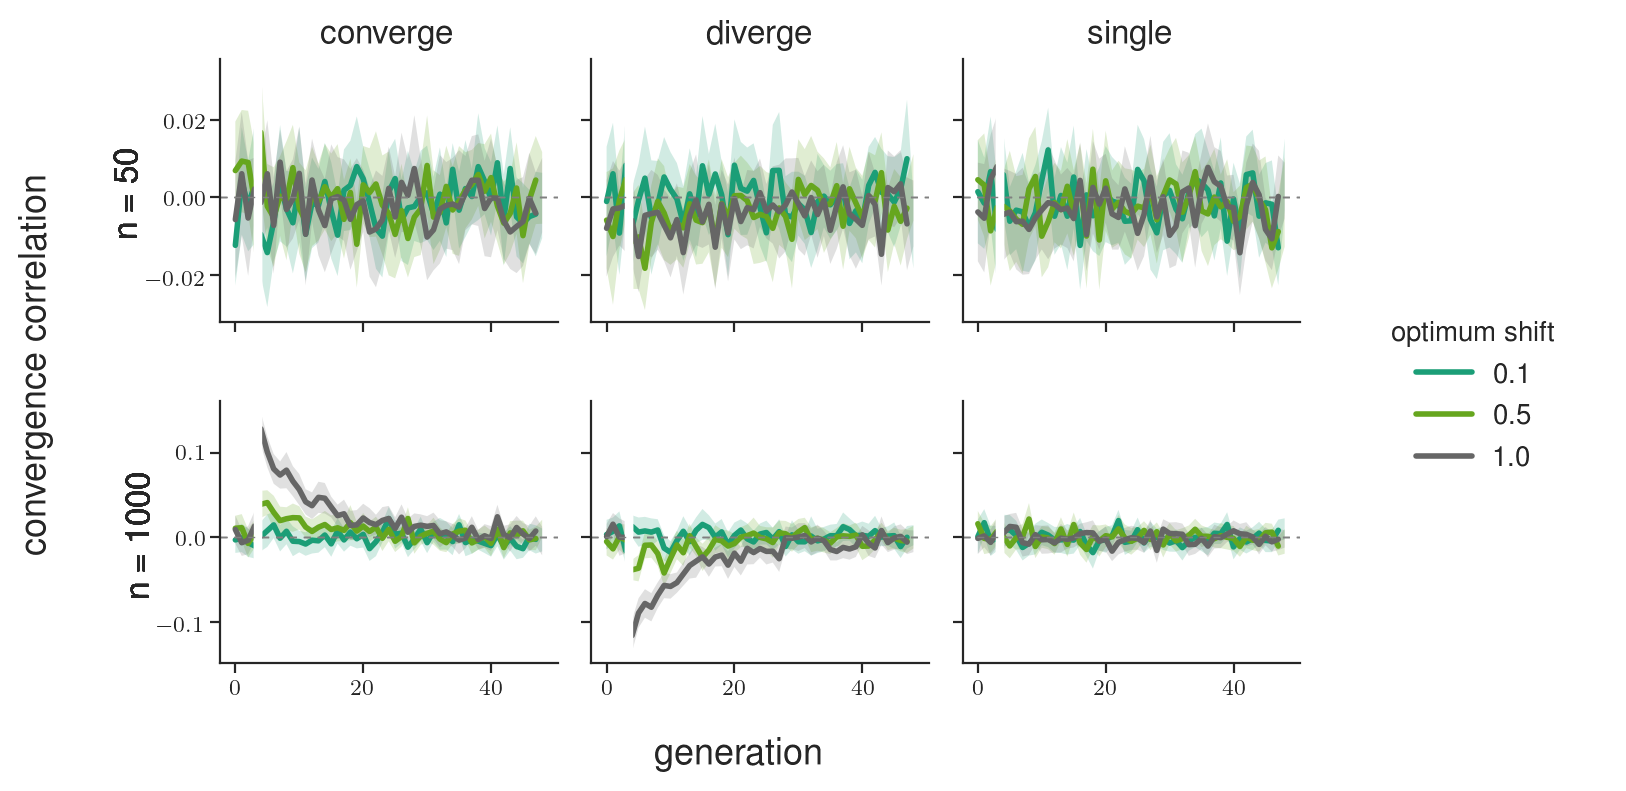

In [456]:
sampleNs = sorted(params_2pop['sampleN'])
modes = sorted(params_2pop['shifttype'])
shifts = sorted(params_2pop['shift'])
shift_cols = col_palette(params_2pop['shift'], cm.Dark2)

ALPHA = 0.05
fig, ax = plt.subplots(nrows = len(sampleNs), ncols=len(modes), 
                       sharey='row', sharex=True)
ref = 5
CI_ALPHA = 0.2
lightgray, darkgray = (0.6, 0.6, 0.6), (0.1, 0.1, 0.1)
pad = 0
use_loess=False
labs = set()

for i, sampleN in enumerate(sampleNs):
    for j, mode in enumerate(modes):
        for shift in shifts:
            d = extract_runs({'shifttype':[mode], 'sampleN':[sampleN], 'shift':[shift]}, covs_2pop_ave)
            assert(len(d.keys()) == 1)
            col = shift_cols[shift]
            for run in list(d.values()):
                cors = run[2][:, 0, ...]
                cor_ave = cors.mean(axis=0)
                n = cor_ave.shape[0]

                idx = (np.arange(n) != ref) & (np.arange(n) < maxgen)
                cor_CI_sim = np.quantile(cors, (ALPHA/2, 1-ALPHA/2), axis=0)
                cor_sd = np.sqrt(np.var(cors, axis=0))
                N = cors.shape[0]
                cor_CI = np.stack((cor_ave - 2 * cor_sd/np.sqrt(N), 
                                   cor_ave + 2 * cor_sd/np.sqrt(N)))
                cor_poly = CI_polygon(np.arange(maxgen-1), 
                            cor_CI[0, ref, idx], cor_CI[1, ref, idx],
                            color=col, alpha=CI_ALPHA,
                            frac=1/3,
                            linewidth=0, smooth=False)
                cor_poly2 = CI_polygon(np.arange(maxgen-1), 
                            cor_CI_sim[0, ref, idx], cor_CI_sim[1, ref, idx],
                            color=col, alpha=0.05,
                            frac=1/3,
                            linewidth=0, smooth=False)
                ax[i, j].add_patch(cor_poly)
                #ax[i, j].add_patch(cor_poly2)
                l1 = np.where((np.arange(n) < ref-1) & (np.arange(n) < maxgen))[0]
                ax[i, j].plot(l1, cor_ave[ref, idx][l1], '-', c=col,
                              solid_capstyle='round',
                              linewidth=2)

                l2 = np.where((np.arange(n) > ref-1) & (np.arange(n) < maxgen-1))[0]
                if use_loess:
                    fit = lowess(cor_ave[ref, idx][l2-1], l2, frac=1/4)
                    ax[i, j].plot(fit[:, 0], fit[:, 1],  c=col, 
                                  linewidth=3,
                                  solid_capstyle='round')
                else:
                    ax[i, j].plot(l2-1, cor_ave[ref, idx][l2-1], '-',  c=col,
                                  linewidth=2, label=shift if shift not in labs else None,
                                  solid_capstyle='round')
                if i == 0:
                    ax[i, j].set_title(f"{mode}")
                ax[i, j].axvline(ref-1.5, c='1', linewidth=3)
                ax[i, j].axhline(0, c='0.5', linewidth=0.5, linestyle=(0, (5, 5)))
                ax[i, 0].annotate(f"n = {sampleN}", xy=(0, 0.5), 
                                  xytext=(ax[i, 0].yaxis.labelpad - pad, 0),
                                  xycoords=ax[i, 0].yaxis.label, textcoords='offset points',
                             size='large', ha='right', va='center', rotation=90)
                #ax[i, j].set_ylim(-0.05, 0.05)
            labs.add(shift)

fig.subplots_adjust(right=0.8, hspace=0.3, wspace=0.1)
fig.text(0, 0.5, "convergence correlation", va="center", fontsize=13, rotation='vertical')
fig.text(0.45, 0, "generation", ha="center", fontsize=13)
fig.legend(loc = 7, frameon=False, ncol=1, title='optimum shift')
fig.subplots_adjust(right=0.8, wspace=0.1)
fig.savefig("plots/fig-convergence-corrs-gss.pdf", bbox_inches='tight')


## Figure for Paper

A few draft figures...

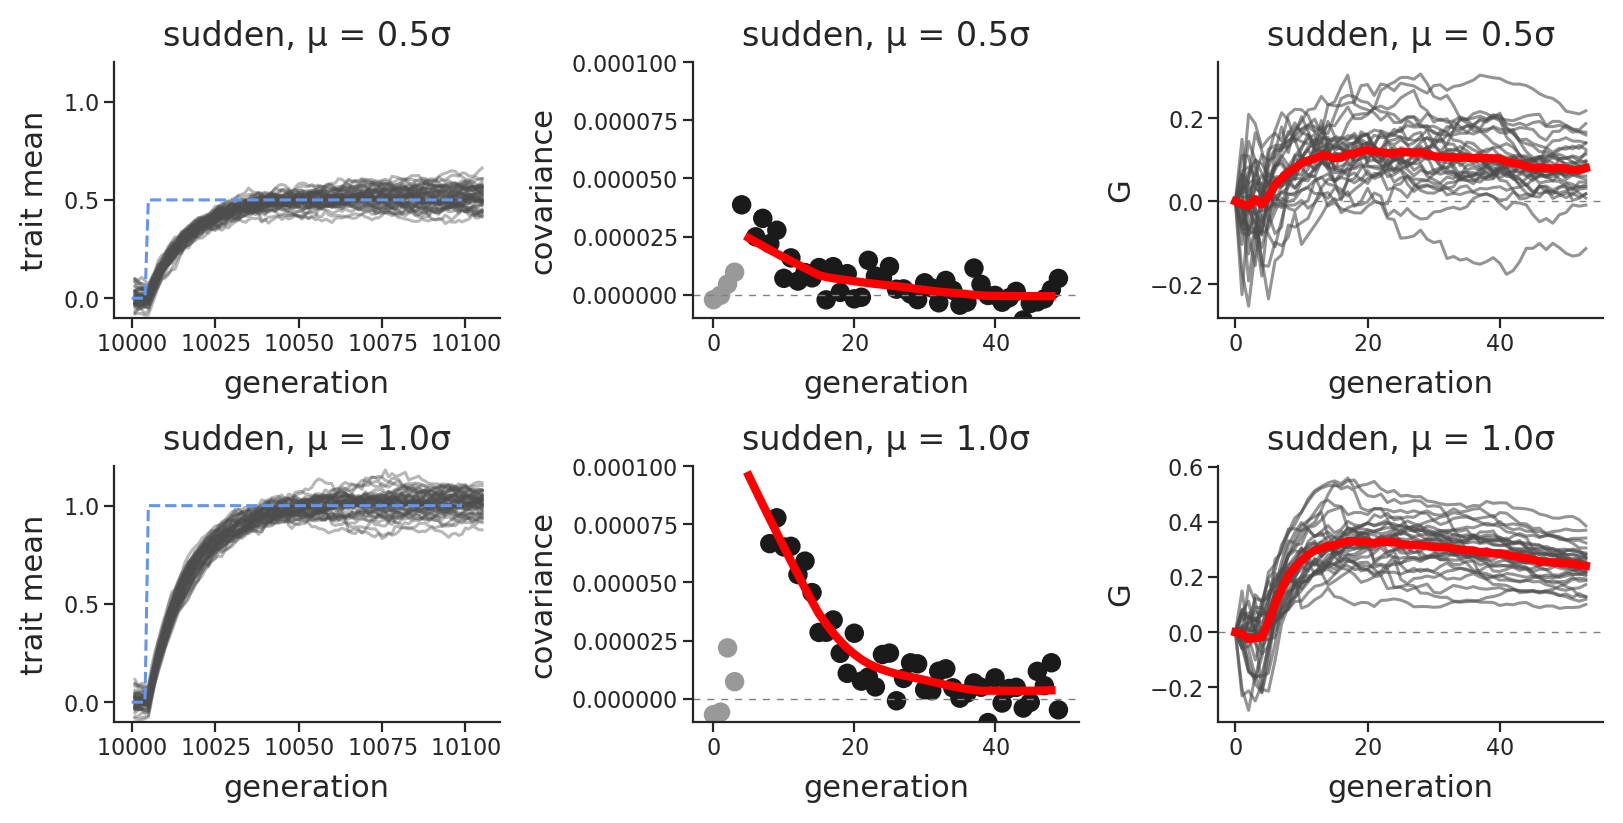

In [281]:
ref = 5
maxgen = 50
yscale = 1

fig = plt.figure(constrained_layout=True)
gs = fig.add_gridspec(2, 3)

axs = [fig.add_subplot(gs[0, 0]),
       fig.add_subplot(gs[1, 0]),
       
       fig.add_subplot(gs[0, 1]),
       fig.add_subplot(gs[1, 1]),
       
       fig.add_subplot(gs[0, 2]),
       fig.add_subplot(gs[1, 2])]

shift_params = [(dict(x)['moving'], dict(x)['shift']) for x in stats_subset]
shift_params_subset = [x for x in shift_params if x[0] == 'F' and x[1] != 0.1]

for (moving, shift), ax in zip(shift_params_subset, axs[0:2]):
    if moving == 'T' or (moving == 'F' and shift == 0.1):
        continue
    d = extract_runs({'shift':[shift]}, stats_subset)
    assert(len(d.keys()) == 1)
    for run in list(d.values())[0]:
        ax.plot(run.generation, run.zbar_1, c='0.3', alpha=0.4)
    ax.set_ylim(-0.1, 1.2)
    ax.set_ylabel('trait mean')
    ax.set_xlabel('generation')
    label = f"{'gradual' if moving == 'T' else 'sudden'}, μ = {shift}σ{'/gen' if moving == 'T' else ''}"
    ax.set_title(label)
    if moving == 'F':
        #ax.axhline(shift, c='cornflowerblue', linestyle='--')
        x = np.arange(10000, 10100)
        y = [shift if i >= 10000 + 5 else 0 for i in x]
        ax.plot(x, y, '--', c='cornflowerblue')
    else:        
        x = np.arange(10000, 10100)
        y = [shift * (i - 10000 - 4) if i >= 10000 + 5 else 0 for i in x]
        ax.plot(x, y, '--', c='cornflowerblue')

covs_plot(stacked_covs_subset, axs[2], 'F', 0.5, ylim=(-0.00001, 0.0001))
covs_plot(stacked_covs_subset, axs[3], 'F', 1.0, ylim=(-0.00001, 0.0001))
G_plot(covs_subset, axs[4], 'F', 0.5)
G_plot(covs_subset, axs[5], 'F', 1.0)


/home/vsb/miniconda3/envs/cvtk/lib/python3.7/site-packages/ipykernel_launcher.py:222: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


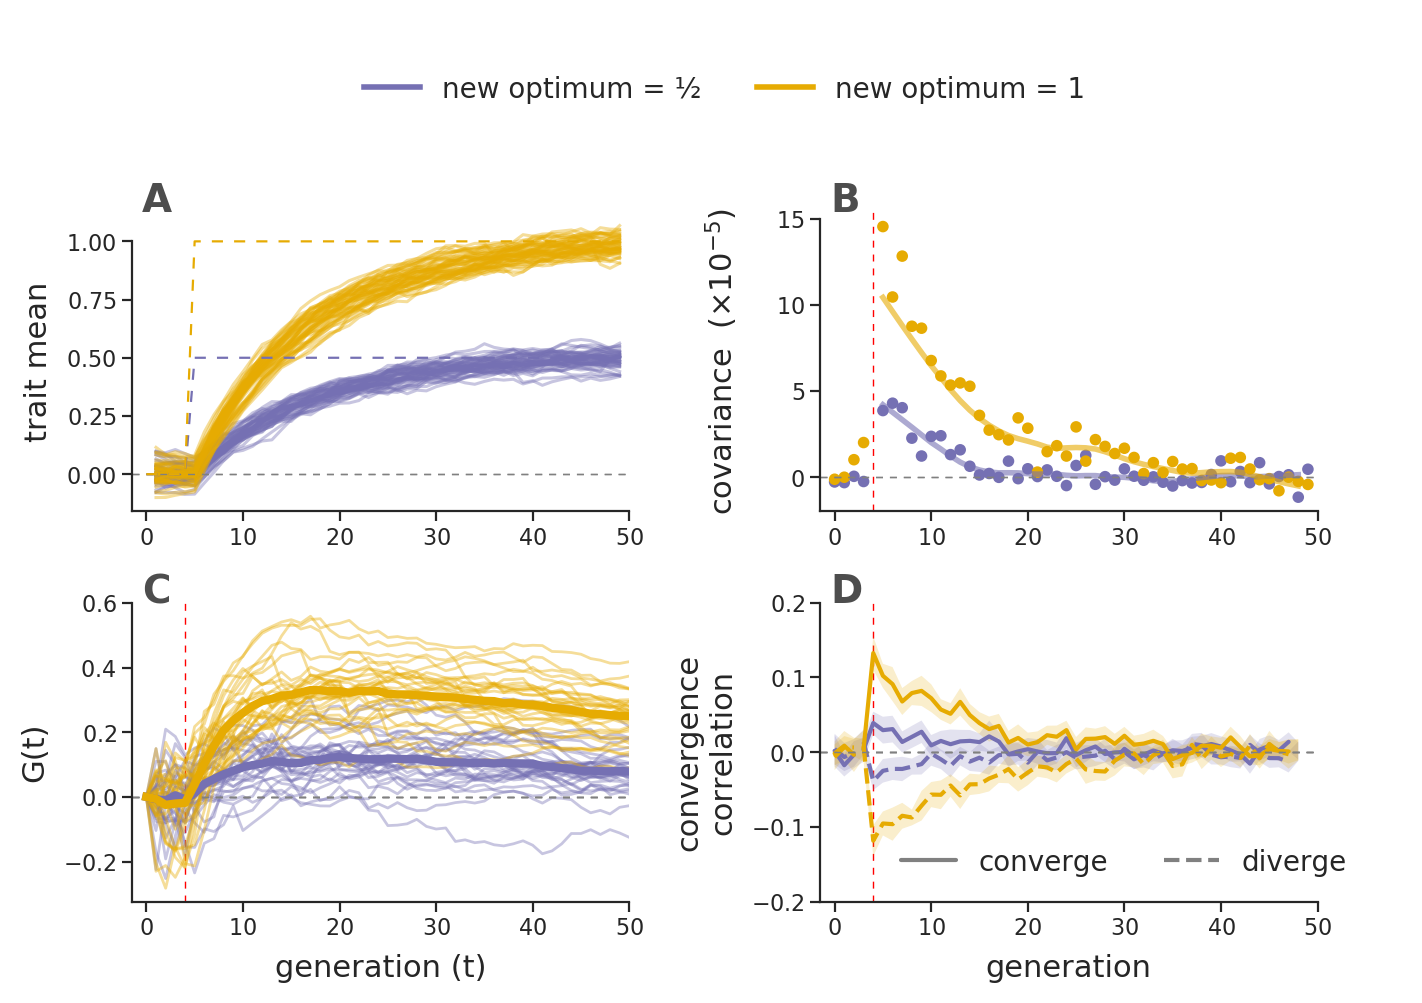

In [897]:
shift_cols = col_palette([0.5, 0.1, 1.0, 2], cm.Dark2)
ref = 4

def fix_spines(ax, connect=True, x=True):
    """
    Beautifies spines by stopping them at the last tick mark. If connect=False,
    also stops them at the first tick mark. For y-axis only, set x=False.
    """
    ylim = ax.get_ylim()
    xlim = ax.get_xlim()
    yticks = ax.get_yticks()
    xticks = ax.get_xticks()
    ylast = yticks[yticks <= ylim[1]][-1]
    xlast = xticks[xticks <= xlim[1]][-1]
    if connect:
        yfirst = ylim[0]
        xfirst = xlim[0]
    else:
        yfirst = yticks[yticks >= ylim[0]][0]
        xfirst = xticks[xticks >= xlim[0]][0]
    ylimits = yfirst, ylast
    xlimits = xfirst, xlast
    ax.spines['left'].set_bounds(*ylimits)
    if x:
        ax.spines['bottom'].set_bounds(*xlimits)

def G_plot2(covs, ax, moving, shift, color='0.3', linecolor='red', linealpha=1.0, Galpha=0.6, title=True):
    d = extract_runs({'shift':[shift]}, covs)
    assert(len(d.keys()) == 1)
    all = []
    for run in list(d.values())[0]:
        ax.plot(run[1][:, 0], c=color, alpha=Galpha, linewidth=1)
        all.append(run[1][:, 0])
    ax.axhline(0, c='0.5', linewidth=0.5, linestyle=(0, (5, 5)))   
    ax.plot(np.stack(all).mean(axis=0), c=linecolor, linewidth=3, alpha=linealpha, zorder=3)
    label = f"{'gradual' if moving == 'T' else 'sudden'}, μ = {shift}σ{'/gen' if moving == 'T' else ''}"
    if title:
        ax.set_title(label)
    ax.set_ylabel('G(t)')
    ax.set_xlabel('generation (t)')
    ax.set_xlim(-1.5, 50)
    ax.axhline(0, c='0.5', linewidth=0.5, linestyle=(0, (5, 5)))
    fix_spines(ax)
    
# hackity hack hack: customized functions for these plots.
def covs_plot2(covs, ax, moving, shift, ylim=None, linewidth=2, yscale=1e5,
              colors = ((0.6, 0.6, 0.6), (0.1, 0.1, 0.1)), title=True,
             linecolor='red', linealpha=1.0):
    d = extract_runs({'shift':[shift]}, covs)
    all = []
    for run in list(d.values()):            
        tempcovs = stack_temporal_covariances(run[0].mean(axis=0), run[3][0], run[3][1])
        n = tempcovs[0].shape[0]
        idx = (np.arange(n) != ref) & (np.arange(n) < maxgen)
        ax.axhline(0, c='0.5', linewidth=0.5, linestyle=(0, (5, 5)))
        # note: disabled gray colors
        cols = [colors[1] if i < ref-1 else colors[1] for i in range(maxgen-1)]
        selgen = np.arange(ref, maxgen-2)+1
        fit = lowess(tempcovs[ref, idx, 1][selgen],
                     selgen, frac=1/4, return_sorted=True)

        ax.plot(fit[:, 0], yscale * fit[:, 1], '-', c=linecolor, linewidth=linewidth, alpha=linealpha)
        ax.scatter(np.where(idx)[0], yscale * tempcovs[ref, idx, 1], c=cols, s=10)
        if ylim is not None:
            ax.set_ylim(*ylim)
        label = f"{'gradual' if moving == 'T' else 'sudden'}, μ = {shift}σ{'/gen' if moving == 'T' else ''}"
        if title:
            ax.set_title(label)
        yscaletext = "  $(\\times 10^{-" + str(int(np.log10(yscale))) + "}$)" if yscale != 1 else ""
        ax.set_ylabel("covariance" + yscaletext, labelpad=13)
        #ax.set_xlabel('generation')
        ax.set_xlim(-1.5, 50)
        fix_spines(ax)

plt.rc('text', usetex=False)

shift_cols = col_palette([0.5, 0.1, 1.0, 2], cm.Dark2)

ref = 4
maxgen = 50
yscale = 1

#fig = plt.figure(constrained_layout=True, figsize=(TWOCOL, TWOCOL*0.7))
width_cm, height_cm = 17.8, 17.8 / 1.58
width, height = width_cm / 2.54, height_cm / 2.54
fig = plt.figure(constrained_layout=True, figsize=(TWOCOL, TWOCOL*0.7))
gs = fig.add_gridspec(3, 2, height_ratios=(0.05, 1, 1))
gs.update(wspace=0.025, hspace=0.05)

axs = [fig.add_subplot(gs[0, 0:2]), 
       fig.add_subplot(gs[1, 0]),  
       fig.add_subplot(gs[1, 1]),       
       fig.add_subplot(gs[2, 0]),
       fig.add_subplot(gs[2, 1])]

shift_params = [(dict(x)['moving'], dict(x)['shift']) for x in stats_subset]
shift_params_subset = [x for x in shift_params if x[0] == 'F' and x[1] != 0.1]
labs = set()

for (moving, shift), ax in zip(shift_params_subset, [axs[1], axs[1]]):
    if moving == 'T' or (moving == 'F' and shift == 0.1):
        continue
    d = extract_runs({'shift':[shift]}, stats_subset)
    assert(len(d.keys()) == 1)
    for run in list(d.values())[0]:
        idx = run.generation.values < 10050
        #lab = '$ ' + ('1' if shift == 1 else '\\frac{1}{2}') + '$ shift'
        lab = 'new optima = ' + ('0.5' if shift == 0.5 else '1')
        ax.plot(run.generation[idx] - 1e4, run.zbar_1[idx], c=shift_cols[shift], alpha=0.4, label=lab if lab not in labs else "")
        labs.add(lab)
#    ax.set_ylim(-0.1, 1.2)
    ax.set_ylabel('trait mean')
    #ax.set_xlabel('generation')
    label = f"{'gradual' if moving == 'T' else 'sudden'}, μ = {shift}σ{'/gen' if moving == 'T' else ''}"
    #ax.set_title(label)
    if moving == 'F':
        #ax.axhline(shift, c='cornflowerblue', linestyle='--')
        x = np.arange(10000, 10050)
        y = [shift if i >= 10000 + 5 else 0 for i in x]
        ax.plot(x - 1e4, y, '-', c=shift_cols[shift], zorder=3, linewidth=0.8, linestyle=(0, (5, 5)))
    else:        
        x = np.arange(10000, 10050)
        y = [shift * (i - 10000 - 4) if i >= 10000 + 5 else 0 for i in x]
        ax.plot(x-1e4, y, '-', c=shift_cols[shift],  linewidth=0.8, linestyle=(0, (5, 5)))
    ax.set_xlim(-1.5, 50)
    ax.axhline(0, c='0.5', linewidth=0.5, linestyle=(0, (5, 5)))
    fix_spines(ax)
    
yscale = 1e5
covs_plot2(stacked_covs_subset, axs[2], 'F', 0.5, colors=(lightgray, shift_cols[0.5]),
           linecolor=shift_cols[0.5], linealpha=0.6, title=False)
covs_plot2(stacked_covs_subset, axs[2], 'F', 1.0, colors=(lightgray, shift_cols[1.0]), 
           linecolor=shift_cols[1.0], linealpha=0.6, title=False)
G_plot2(covs_subset, axs[3], 'F', 0.5, color=shift_cols[0.5], linecolor=shift_cols[0.5], linealpha=1, Galpha=0.4, title=False)
G_plot2(covs_subset, axs[3], 'F', 1.0, color=shift_cols[1.0], linecolor=shift_cols[1.0], linealpha=1, Galpha=0.4, title=False)


labs = set()
for shift in [0.5, 1]:
    for mode in ['converge', 'diverge']:
        d = extract_runs({'shifttype':[mode], 'sampleN':[1000], 'shift':[shift]}, covs_2pop_ave)
        assert(len(d.keys()) == 1)
        col = shift_cols[shift]
        for run in list(d.values()):
            cors = run[2][:, 0, ...]
            cor_ave = cors.mean(axis=0)
            n = cor_ave.shape[0]

            idx = (np.arange(n) != ref) & (np.arange(n) < maxgen)
            cor_CI_sim = np.quantile(cors, (ALPHA/2, 1-ALPHA/2), axis=0)
            cor_sd = np.sqrt(np.var(cors, axis=0))
            N = cors.shape[0]
            cor_CI = np.stack((cor_ave - 2 * cor_sd/np.sqrt(N), 
                               cor_ave + 2 * cor_sd/np.sqrt(N)))
            cor_poly = CI_polygon(np.arange(maxgen-1), 
                        cor_CI[0, ref, idx], cor_CI[1, ref, idx],
                        color=col, alpha=CI_ALPHA,
                        frac=1/3,
                        linewidth=0, smooth=False)
            cor_poly2 = CI_polygon(np.arange(maxgen-1), 
                        cor_CI_sim[0, ref, idx], cor_CI_sim[1, ref, idx],
                        color=col, alpha=0.05,
                        frac=1/3,
                        linewidth=0, smooth=False)
            axs[4].add_patch(cor_poly)
            #ax[i, j].add_patch(cor_poly2)
            l1 = np.where((np.arange(n) < ref-1) & (np.arange(n) < maxgen))[0]
            lstyle = '-' if mode == 'converge' else '--'
            axs[4].plot(l1, cor_ave[ref, idx][l1], '-', c=col,
                          solid_capstyle='round', linestyle=lstyle,
                          linewidth=1.5)

            l2 = np.where((np.arange(n) > ref-1) & (np.arange(n) < maxgen-1))[0]
            if use_loess:
                fit = lowess(cor_ave[ref, idx][l2-1], l2, frac=1/4)
                axs[4].plot(fit[:, 0], fit[:, 1],  c=col, 
                              linewidth=1.5,
                              linestyle=lstyle,
                              solid_capstyle='round')
            else:
                axs[4].plot(l2-1, cor_ave[ref, idx][l2-1], '-',  c=col,
                              linewidth=1.5, label=mode if mode not in labs else '',
                              linestyle=lstyle,
                              solid_capstyle='round')
                labs.add(mode)
            #axs[3].axvline(ref-1.5, c='1', linewidth=3)
            axs[4].axhline(0, c='0.5', linewidth=0.5, linestyle=(0, (5, 5)))
            axs[4].set_ylabel("convergence\ncorrelation")
            axs[4].set_xlabel('generation')
            axs[4].set_xlim(-1.5, 50)
            axs[4].set_ylim(-0.2, 0.2)
            fix_spines(axs[4])
            leg = axs[4].legend(loc=(0.05, -0.1), ncol=2)
            for lh in leg.legendHandles: 
                lh.set_color('gray')

from matplotlib.lines import Line2D
lines = [Line2D([0], [0], color=shift_cols[0.5], lw=4),
         Line2D([0], [0], color=shift_cols[1.0], lw=4)]

leg = axs[0].legend(lines, ['new optimum = ½', 'new optimum = 1'], ncol=2, loc='lower center', bbox_to_anchor=(0.5, -5))
axs[0].axis('off')

for lh in leg.legendHandles: 
    lh.set_alpha(1)
    lh.set_linewidth(2)
    
weight = 'bold'
style= 'normal'
col = '0.3'
axs[1].annotate("A", (0.02, 1), xycoords='axes fraction', fontfamily='helvetica', fontstyle = style, color=col, weight=weight, fontsize=14)
axs[2].annotate("B", (0.02, 1), xycoords='axes fraction', fontfamily='helvetica',  fontstyle = style, color=col, weight=weight, fontsize=14)
axs[3].annotate("C", (0.02, 1), xycoords='axes fraction', fontfamily='helvetica', fontstyle = style, color=col, weight=weight, fontsize=14)
axs[4].annotate("D", (0.02, 1), xycoords='axes fraction', fontfamily='helvetica',  fontstyle = style, color=col, weight=weight, fontsize=14)

axs[2].axvline(4, c='r', linewidth=0.5, linestyle=(0, (5, 5)), zorder=-1)
axs[3].axvline(4, c='r', linewidth=0.5, linestyle=(0, (5, 5)), zorder=-1)
axs[4].axvline(4, c='r', linewidth=0.5, linestyle=(0, (5, 5)), zorder=-1)

axs[0].margins(0, tight=True)

plt.tight_layout()
fig.savefig("plots/figure-4.pdf", bbox_inches='tight')

In [815]:
len(covs_subset[(('N', 1000),
              ('Vs', '1'),
              ('alpha', 0.01),
              ('moving', 'T'),
              ('nmu', 1e-08),
              ('rbp', 1e-08),
              ('region_length', 50000000),
              ('sampleN', 1000),
              ('shift', 0.001),
              ('shifttime', 5),
              ('shifttype', 'converge'),
              ('tmu',
               1e-08))])

30

(-0.32475571114312524, 0.6014224254636786)

In [497]:
d.keys()

dict_keys([(('N', 1000), ('Vs', '1'), ('alpha', 0.01), ('moving', 'F'), ('nmu', 1e-08), ('rbp', 1e-08), ('region_length', 50000000), ('sampleN', 1000), ('shift', 1.0), ('shifttime', 5), ('shifttype', 'diverge'), ('tmu', 1e-08))])